# AutoEncoders

Roland Kwitt     
University of Salzburg (2019)

---

In this lecture, we we build our first simple (fully-connected) **autoencoder** (for MNIST images), i.e., a popular technique for unsupervised **representation learning**. Bascially, an autoencoder implements a mapping

$$ f_{\theta} \circ g_{\phi}: \mathbb{R}^d \to \mathbb{R}^d$$

Here, we refer to $g_{\phi}: \mathbb{R}^d \to Z$ as an *encoder* and to $f_{\theta}: Z \to \mathbb{R}^l$ as a *decoder*. In general, we have $Z \subset \mathbb{R}^l$ (with $l < d$) and we
call $Z$ the *representation space* (or *latent* space).

Typically, we train autoencoders to *reconstruct* the input, e.g., by measuring the *mean-squared error* of the difference between the input and the output. 

**Note**: There is no supervisory signal as in supervised learning (e.g., the class labels).

Below is a conceptual illustration of the basic architecture.

![Bottleneck](AutoEncLecture.png "AutoEncoder")

In [1]:
%matplotlib inline

import torch
import torch.utils.data

from torch import nn
from torch import optim
from torch.nn import functional as F

from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")

First, we create our data loaders ...

In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data_mnist/', 
                   train=True, 
                   download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data_mnist/', 
                   train=False, 
                   transform=transforms.ToTensor()),
    batch_size=128, 
    shuffle=True)

Next, we define our autoencoder model. In particular, inputs will be of size $28 \times 28$ as our MNIST images are binary images of that spatial size. 

We will flatten the images and just use linear layers with ReLU activations for now. Later, we will refine this model to implement a *convolutional autoencoder*.

In [3]:
class AutoEnc(nn.Module):
    def __init__(self):
        super(AutoEnc, self).__init__()

        # Define our linear layers, latent representation dim. is 20 here!
        self.fc1  = nn.Linear(784, 400)
        self.fc2  = nn.Linear(400, 20)
        self.fc3  = nn.Linear(20, 400)
        self.fc4  = nn.Linear(400, 784)
        
    # implement the encoder (Lin.->ReLU->Lin.)
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2(h1)

    # implement the decoder (Lin.->ReLU->Sigmoid)
    # we use a sigmoid at the end, as we want outputs in [0,1]
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # implement the forward pass, i.e., encoder->decoder
    def forward(self, x):
        z = self.encode(x.view(-1, 784)) # 28*28=784
        return z, self.decode(z)

We can now instantiate that model, define an optimizer and write our train and test routines.

In [4]:
model = AutoEnc().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x):
    """
    As loss, we use binary cross entropy - remember our inputs are in {0,1}
    and the output of the autoencoder model is in [0,1], so this is a valid
    choice; reduction='sum' means that the reconstruction loss is not averaged,
    but just summed up!
    """
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    return BCE


def train(epoch):
    model.train()
    
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        
        data = data.to(device)
        
        # reset gradients to 0
        optimizer.zero_grad()
        
        # forward batch of data through model
        _, recon_batch = model(data)
        
        # compute reconstruction loss
        loss = loss_function(recon_batch, data)
        
        # compute gradients 
        loss.backward()
        
        train_loss += loss.item()
        
        # take an optimizer step
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            _, recon_batch = model(data)
            test_loss += loss_function(recon_batch, data).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [5]:
n_epochs = 2
for epoch in range(1, n_epochs+1):
    train(epoch)
    test(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.572998
Train Epoch: 1 [12800/60000 (21%)]	Loss: 149.119110
Train Epoch: 1 [25600/60000 (43%)]	Loss: 117.325790
Train Epoch: 1 [38400/60000 (64%)]	Loss: 103.293037
Train Epoch: 1 [51200/60000 (85%)]	Loss: 92.511063
====> Epoch: 1 Average loss: 130.3712
====> Test set loss: 87.7007
Train Epoch: 2 [0/60000 (0%)]	Loss: 87.127640
Train Epoch: 2 [12800/60000 (21%)]	Loss: 80.659508
Train Epoch: 2 [25600/60000 (43%)]	Loss: 81.781433
Train Epoch: 2 [38400/60000 (64%)]	Loss: 79.502968
Train Epoch: 2 [51200/60000 (85%)]	Loss: 82.748611
====> Epoch: 2 Average loss: 82.8555
====> Test set loss: 78.0298


Visualize original data and reconstructions ...

In [6]:
B = next(iter(test_loader))[0].to(device)
z, recon = model(B)
print(z.size())

torch.Size([128, 20])


Text(0.5, 1.0, 'Reconstructions (on testing data)')

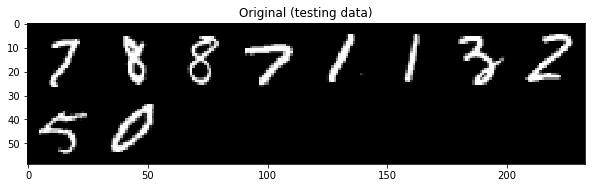

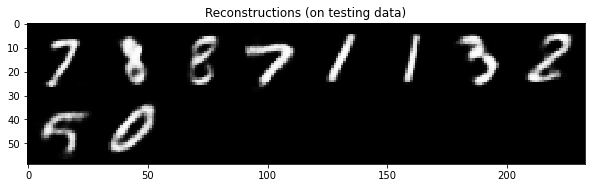

In [7]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

B = next(iter(test_loader))[0].to(device)
z, R = model(B)

plt.figure(figsize=(10,5))
show(make_grid(B[0:10,:,:,:].cpu(), padding=1))  
plt.title('Original (testing data)');

plt.figure(figsize=(10,5))
show(make_grid(R.view((128,1,28,28))[0:10,:,:,:].detach().cpu(), padding=1))     
plt.title('Reconstructions (on testing data)')

## Visualizing the represenation space

To visualize the representations learned by an autoencoder, we use UMAP    

McInnes et al.    
*UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction*    
[PDF](https://arxiv.org/abs/1802.03426)


In [8]:
latents = []
llabels = []

model.eval()
for x, y in test_loader:
    with torch.no_grad():
        x = x.to(device)
        y = y.to(device)        
        z, R = model(x)
        latents.append(z.detach().cpu().numpy())
        llabels.append(y.detach().cpu().numpy())

In [9]:
X = np.concatenate(latents)
Y = np.concatenate(llabels)
idx = np.random.randint(0,X.shape[0],2000)
Xs = X[idx,:]
Ys = Y[idx]

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(Xs)
print(embedding.shape)

(2000, 2)


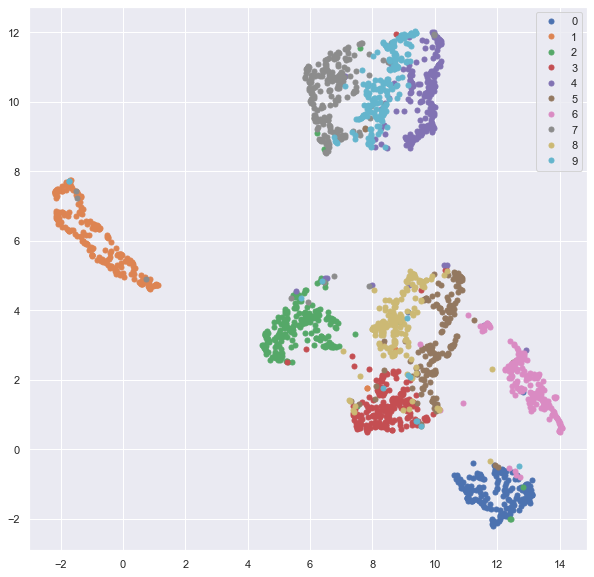

In [13]:
import seaborn as sns
sns.set()
plt.figure(figsize=(10,10))
for i in range(10):
    plt.plot(
        embedding[Ys==i,0], 
        embedding[Ys==i,1],'.',
        markersize=10, label='{}'.format(i))
plt.legend();